[View in Colaboratory](https://colab.research.google.com/github/sahilvora10/CIFAR-10/blob/master/CIFAR_10.ipynb)

# ** CIFAR - 10 **

We will classify  the CIFAR-10 dataset containing 60,000 images into 10 label classes.
We will use CNN using Keras over Tensorflow.

The next few blocks are to run Keras in Google Colab

In [0]:
!pip install -q keras
!pip install -q tqdm

#openCV is used to process and filter images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# print 'Files in Drive:'
!ls drive/

Here are few Libraries which are very important.

In [6]:
from __future__ import print_function, division

import keras as keras
import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**LOAD THE DATASET AND PREPROCESS IT.**

170500096/170498071 [==============================] - 16s 0us/step


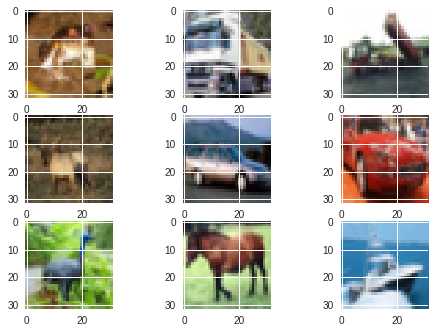

In [7]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

In [0]:
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [0]:
# load data
(X, y), (X_test, y_test) = cifar10.load_data()

In [0]:
X_train = X[:40000]
y_train = y[:40000]
X_valid = X[40000:]
y_valid = y[40000:]


In [0]:

y_train.shape

(40000, 1)

In [0]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')                         
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [0]:
X_train.shape


(40000, 3, 32, 32)

In [0]:
num_classes

10

***BUILD FIRST MODEL AND COMPILE IT.***

In [15]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3,32, 32), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
nadam=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

***FIT THE MODEL***

In [17]:
# Fit the model
model1=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=32)
# Final evaluation of the model
#scores = model.evaluate(X_valid, y_valid, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 27s 684us/step - loss: 0.7238 - acc: 0.7468 - val_loss: 0.8613 - val_acc: 0.7017
Epoch 2/25
12064/40000 [========>.....................] - ETA: 18s - loss: 0.6072 - acc: 0.7885

40000/40000 [==============================] - 28s 691us/step - loss: 0.7029 - acc: 0.7539 - val_loss: 0.8701 - val_acc: 0.7003
Epoch 3/25
31392/40000 [======================>.......] - ETA: 5s - loss: 0.6601 - acc: 0.7695

40000/40000 [==============================] - 28s 688us/step - loss: 0.6831 - acc: 0.7611 - val_loss: 0.8698 - val_acc: 0.6976
Epoch 4/25
39360/40000 [============================>.] - ETA: 0s - loss: 0.6614 - acc: 0.7691

40000/40000 [==============================] - 27s 675us/step - loss: 0.6628 - acc: 0.7685 - val_loss: 0.8719 - val_acc: 0.6999
Epoch 5/25
40000/40000 [==============================] - 27s 681us/step - loss: 0.6425 - acc: 0.7757 - val_loss: 0.8632 - val_acc: 0.7044
Epoch 6/25
 1280/40000 [..............................] - ETA: 25s - loss: 0.5146 - acc: 0.8219

40000/40000 [==============================] - 27s 678us/step - loss: 0.6264 - acc: 0.7823 - val_loss: 0.8966 - val_acc: 0.6972
Epoch 7/25
27808/40000 [===================>..........] - ETA: 7s - loss: 0.5847 - acc: 0.7967

40000/40000 [==============================] - 27s 669us/step - loss: 0.6284 - acc: 0.7808 - val_loss: 0.8876 - val_acc: 0.6935
Epoch 8/25
37344/40000 [===========================>..] - ETA: 1s - loss: 0.6072 - acc: 0.7878

40000/40000 [==============================] - 27s 680us/step - loss: 0.6138 - acc: 0.7852 - val_loss: 0.8958 - val_acc: 0.6999
Epoch 9/25
40000/40000 [==============================] - 27s 686us/step - loss: 0.5917 - acc: 0.7922 - val_loss: 0.8994 - val_acc: 0.6949
Epoch 10/25
  704/40000 [..............................] - ETA: 26s - loss: 0.4864 - acc: 0.8253

40000/40000 [==============================] - 27s 684us/step - loss: 0.5941 - acc: 0.7922 - val_loss: 0.9067 - val_acc: 0.6923
Epoch 11/25
27520/40000 [===================>..........] - ETA: 8s - loss: 0.5412 - acc: 0.8113

40000/40000 [==============================] - 27s 683us/step - loss: 0.5864 - acc: 0.7941 - val_loss: 0.8704 - val_acc: 0.7066
Epoch 12/25
36736/40000 [==========================>...] - ETA: 2s - loss: 0.5659 - acc: 0.8019

40000/40000 [==============================] - 28s 697us/step - loss: 0.5750 - acc: 0.7987 - val_loss: 0.9101 - val_acc: 0.6916
Epoch 13/25
40000/40000 [==============================] - 27s 687us/step - loss: 0.5642 - acc: 0.8045 - val_loss: 0.9107 - val_acc: 0.6869
Epoch 14/25
  416/40000 [..............................] - ETA: 25s - loss: 0.4338 - acc: 0.8726

40000/40000 [==============================] - 27s 687us/step - loss: 0.5630 - acc: 0.8029 - val_loss: 0.9413 - val_acc: 0.6801
Epoch 15/25
27424/40000 [===================>..........] - ETA: 8s - loss: 0.5123 - acc: 0.8217

40000/40000 [==============================] - 27s 674us/step - loss: 0.5607 - acc: 0.8056 - val_loss: 0.8924 - val_acc: 0.6973
Epoch 16/25
37824/40000 [===========================>..] - ETA: 1s - loss: 0.5466 - acc: 0.8110

40000/40000 [==============================] - 27s 674us/step - loss: 0.5533 - acc: 0.8087 - val_loss: 0.9115 - val_acc: 0.7067
Epoch 17/25
39808/40000 [============================>.] - ETA: 0s - loss: 0.5484 - acc: 0.8104

40000/40000 [==============================] - 28s 701us/step - loss: 0.5488 - acc: 0.8102 - val_loss: 0.8640 - val_acc: 0.7076
Epoch 18/25
40000/40000 [==============================] - 28s 710us/step - loss: 0.5408 - acc: 0.8113 - val_loss: 0.8658 - val_acc: 0.7090
Epoch 19/25
  224/40000 [..............................] - ETA: 26s - loss: 0.4028 - acc: 0.8884

40000/40000 [==============================] - 27s 667us/step - loss: 0.5363 - acc: 0.8139 - val_loss: 0.9083 - val_acc: 0.6956
Epoch 20/25
27680/40000 [===================>..........] - ETA: 7s - loss: 0.4884 - acc: 0.8324

40000/40000 [==============================] - 27s 666us/step - loss: 0.5340 - acc: 0.8151 - val_loss: 0.9072 - val_acc: 0.6995
Epoch 21/25
37984/40000 [===========================>..] - ETA: 1s - loss: 0.5310 - acc: 0.8181

40000/40000 [==============================] - 27s 666us/step - loss: 0.5366 - acc: 0.8161 - val_loss: 0.8823 - val_acc: 0.7021
Epoch 22/25
40000/40000 [==============================] - 27s 687us/step - loss: 0.5326 - acc: 0.8146 - val_loss: 0.8678 - val_acc: 0.7059
Epoch 23/25
  768/40000 [..............................] - ETA: 26s - loss: 0.4565 - acc: 0.8333

40000/40000 [==============================] - 27s 680us/step - loss: 0.5245 - acc: 0.8181 - val_loss: 0.8808 - val_acc: 0.6987
Epoch 24/25
27712/40000 [===================>..........] - ETA: 8s - loss: 0.4739 - acc: 0.8374

40000/40000 [==============================] - 27s 680us/step - loss: 0.5189 - acc: 0.8227 - val_loss: 0.8971 - val_acc: 0.7046
Epoch 25/25
38016/40000 [===========================>..] - ETA: 1s - loss: 0.5218 - acc: 0.8177

40000/40000 [==============================] - 27s 672us/step - loss: 0.5304 - acc: 0.8150 - val_loss: 0.9023 - val_acc: 0.7004


*WE GOT AN ACCURACY of ~70%, this is not a good number.*

***WE BUILD ANOTHER MODEL ,THIS IS MORE DEEP AND WITH MORE LAYERS.***

In [0]:
from keras.layers.normalization import BatchNormalization

In [0]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 50
lrate = 0.01
decay = lrate/epochs
nadam=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 16, 16)        18496     
__________

We save each epoch value using the below code.

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

***FIT THE MODEL***

In [0]:
# Fit the model
modeldetais = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=32,callbacks=[history])
# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
22208/40000 [===============>..............] - ETA: 32s - loss: 1.8998 - acc: 0.3106

40000/40000 [==============================] - 74s 2ms/step - loss: 1.6922 - acc: 0.3859 - val_loss: 1.1640 - val_acc: 0.5800
Epoch 2/50
 8128/40000 [=====>........................] - ETA: 51s - loss: 1.2395 - acc: 0.5502

40000/40000 [==============================] - 70s 2ms/step - loss: 1.1331 - acc: 0.5952 - val_loss: 0.9238 - val_acc: 0.6797
Epoch 3/50
 3712/40000 [=>............................] - ETA: 54s - loss: 0.9625 - acc: 0.6657

40000/40000 [==============================] - 62s 2ms/step - loss: 0.9124 - acc: 0.6825 - val_loss: 0.7367 - val_acc: 0.7425
Epoch 4/50
11712/40000 [=======>......................] - ETA: 40s - loss: 0.7875 - acc: 0.7297

40000/40000 [==============================] - 61s 2ms/step - loss: 0.7816 - acc: 0.7294 - val_loss: 0.7510 - val_acc: 0.7387
Epoch 5/50
16288/40000 [===========>..................] - ETA: 33s - loss: 0.6828 - acc: 0.7633

40000/40000 [==============================] - 59s 1ms/step - loss: 0.6881 - acc: 0.7626 - val_loss: 0.6410 - val_acc: 0.7775
Epoch 6/50
19232/40000 [=============>................] - ETA: 28s - loss: 0.6083 - acc: 0.7870

40000/40000 [==============================] - 57s 1ms/step - loss: 0.6145 - acc: 0.7859 - val_loss: 0.6347 - val_acc: 0.7834
Epoch 7/50
20736/40000 [==============>...............] - ETA: 25s - loss: 0.5514 - acc: 0.8083

40000/40000 [==============================] - 57s 1ms/step - loss: 0.5566 - acc: 0.8084 - val_loss: 0.5843 - val_acc: 0.7989
Epoch 8/50
20960/40000 [==============>...............] - ETA: 26s - loss: 0.5010 - acc: 0.8251

40000/40000 [==============================] - 57s 1ms/step - loss: 0.5038 - acc: 0.8240 - val_loss: 0.6357 - val_acc: 0.7908
Epoch 9/50
21248/40000 [==============>...............] - ETA: 25s - loss: 0.4475 - acc: 0.8447

40000/40000 [==============================] - 57s 1ms/step - loss: 0.4661 - acc: 0.8380 - val_loss: 0.5705 - val_acc: 0.8073
Epoch 10/50
21216/40000 [==============>...............] - ETA: 25s - loss: 0.4066 - acc: 0.8588

40000/40000 [==============================] - 57s 1ms/step - loss: 0.4253 - acc: 0.8511 - val_loss: 0.5393 - val_acc: 0.8182
Epoch 11/50
21120/40000 [==============>...............] - ETA: 25s - loss: 0.3744 - acc: 0.8696

40000/40000 [==============================] - 57s 1ms/step - loss: 0.3922 - acc: 0.8638 - val_loss: 0.5554 - val_acc: 0.8177
Epoch 12/50
20768/40000 [==============>...............] - ETA: 27s - loss: 0.3533 - acc: 0.8735

40000/40000 [==============================] - 60s 1ms/step - loss: 0.3696 - acc: 0.8677 - val_loss: 0.5310 - val_acc: 0.8266
Epoch 13/50
19968/40000 [=============>................] - ETA: 28s - loss: 0.3155 - acc: 0.8881

40000/40000 [==============================] - 60s 2ms/step - loss: 0.3378 - acc: 0.8811 - val_loss: 0.5117 - val_acc: 0.8309
Epoch 14/50
19360/40000 [=============>................] - ETA: 29s - loss: 0.2961 - acc: 0.8966

40000/40000 [==============================] - 61s 2ms/step - loss: 0.3208 - acc: 0.8878 - val_loss: 0.5182 - val_acc: 0.8308
Epoch 15/50
19520/40000 [=============>................] - ETA: 29s - loss: 0.2748 - acc: 0.9050

40000/40000 [==============================] - 60s 2ms/step - loss: 0.2980 - acc: 0.8967 - val_loss: 0.5483 - val_acc: 0.8266
Epoch 16/50
19168/40000 [=============>................] - ETA: 29s - loss: 0.2611 - acc: 0.9063

40000/40000 [==============================] - 60s 2ms/step - loss: 0.2816 - acc: 0.9007 - val_loss: 0.5471 - val_acc: 0.8290
Epoch 17/50
15104/40000 [==========>...................] - ETA: 37s - loss: 0.2419 - acc: 0.9153

40000/40000 [==============================] - 65s 2ms/step - loss: 0.2629 - acc: 0.9088 - val_loss: 0.5202 - val_acc: 0.8347
Epoch 18/50
10560/40000 [======>.......................] - ETA: 43s - loss: 0.2297 - acc: 0.9174

40000/40000 [==============================] - 63s 2ms/step - loss: 0.2594 - acc: 0.9091 - val_loss: 0.5054 - val_acc: 0.8355
Epoch 19/50
12000/40000 [========>.....................] - ETA: 41s - loss: 0.2022 - acc: 0.9285

40000/40000 [==============================] - 62s 2ms/step - loss: 0.2416 - acc: 0.9169 - val_loss: 0.5607 - val_acc: 0.8237
Epoch 20/50
16160/40000 [===========>..................] - ETA: 32s - loss: 0.2125 - acc: 0.9251

40000/40000 [==============================] - 59s 1ms/step - loss: 0.2345 - acc: 0.9166 - val_loss: 0.5679 - val_acc: 0.8284
Epoch 21/50
18816/40000 [=============>................] - ETA: 29s - loss: 0.2101 - acc: 0.9273

40000/40000 [==============================] - 59s 1ms/step - loss: 0.2236 - acc: 0.9216 - val_loss: 0.5148 - val_acc: 0.8369
Epoch 22/50
19520/40000 [=============>................] - ETA: 29s - loss: 0.1919 - acc: 0.9338

40000/40000 [==============================] - 62s 2ms/step - loss: 0.2141 - acc: 0.9256 - val_loss: 0.5252 - val_acc: 0.8397
Epoch 23/50
 8832/40000 [=====>........................] - ETA: 53s - loss: 0.1831 - acc: 0.9373

40000/40000 [==============================] - 71s 2ms/step - loss: 0.2057 - acc: 0.9282 - val_loss: 0.5239 - val_acc: 0.8377
Epoch 24/50
 4832/40000 [==>...........................] - ETA: 51s - loss: 0.1717 - acc: 0.9427

40000/40000 [==============================] - 62s 2ms/step - loss: 0.2011 - acc: 0.9304 - val_loss: 0.5335 - val_acc: 0.8357
Epoch 25/50
12256/40000 [========>.....................] - ETA: 40s - loss: 0.1745 - acc: 0.9385

40000/40000 [==============================] - 62s 2ms/step - loss: 0.1951 - acc: 0.9311 - val_loss: 0.5301 - val_acc: 0.8441
Epoch 26/50
15968/40000 [==========>...................] - ETA: 35s - loss: 0.1796 - acc: 0.9392

40000/40000 [==============================] - 62s 2ms/step - loss: 0.1957 - acc: 0.9318 - val_loss: 0.5515 - val_acc: 0.8379
Epoch 27/50
16384/40000 [===========>..................] - ETA: 34s - loss: 0.1628 - acc: 0.9407

40000/40000 [==============================] - 62s 2ms/step - loss: 0.1864 - acc: 0.9338 - val_loss: 0.5774 - val_acc: 0.8409
Epoch 28/50
16096/40000 [===========>..................] - ETA: 34s - loss: 0.1537 - acc: 0.9476

40000/40000 [==============================] - 65s 2ms/step - loss: 0.1794 - acc: 0.9377 - val_loss: 0.5474 - val_acc: 0.8362
Epoch 29/50
13184/40000 [========>.....................] - ETA: 38s - loss: 0.1516 - acc: 0.9480

40000/40000 [==============================] - 60s 2ms/step - loss: 0.1760 - acc: 0.9402 - val_loss: 0.5465 - val_acc: 0.8372
Epoch 30/50
17472/40000 [============>.................] - ETA: 31s - loss: 0.1505 - acc: 0.9471

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1725 - acc: 0.9396 - val_loss: 0.5657 - val_acc: 0.8388
Epoch 31/50
19168/40000 [=============>................] - ETA: 29s - loss: 0.1586 - acc: 0.9465

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1753 - acc: 0.9397 - val_loss: 0.5516 - val_acc: 0.8448
Epoch 32/50
19872/40000 [=============>................] - ETA: 28s - loss: 0.1435 - acc: 0.9501

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1631 - acc: 0.9440 - val_loss: 0.5765 - val_acc: 0.8449
Epoch 33/50
20160/40000 [==============>...............] - ETA: 27s - loss: 0.1507 - acc: 0.9477

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1648 - acc: 0.9438 - val_loss: 0.6031 - val_acc: 0.8444
Epoch 34/50
20320/40000 [==============>...............] - ETA: 27s - loss: 0.1474 - acc: 0.9512

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1645 - acc: 0.9446 - val_loss: 0.5807 - val_acc: 0.8397
Epoch 35/50
20576/40000 [==============>...............] - ETA: 27s - loss: 0.1409 - acc: 0.9531

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1571 - acc: 0.9469 - val_loss: 0.5835 - val_acc: 0.8470
Epoch 36/50
20512/40000 [==============>...............] - ETA: 27s - loss: 0.1395 - acc: 0.9518

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1556 - acc: 0.9458 - val_loss: 0.5618 - val_acc: 0.8368
Epoch 37/50
20288/40000 [==============>...............] - ETA: 27s - loss: 0.1417 - acc: 0.9504

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1529 - acc: 0.9474 - val_loss: 0.5606 - val_acc: 0.8494
Epoch 38/50
19136/40000 [=============>................] - ETA: 29s - loss: 0.1383 - acc: 0.9528

40000/40000 [==============================] - 62s 2ms/step - loss: 0.1511 - acc: 0.9482 - val_loss: 0.5702 - val_acc: 0.8406
Epoch 39/50
15872/40000 [==========>...................] - ETA: 35s - loss: 0.1309 - acc: 0.9546

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1512 - acc: 0.9477 - val_loss: 0.5635 - val_acc: 0.8444
Epoch 40/50
14272/40000 [=========>....................] - ETA: 38s - loss: 0.1340 - acc: 0.9521

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1494 - acc: 0.9483 - val_loss: 0.5708 - val_acc: 0.8497
Epoch 41/50
13696/40000 [=========>....................] - ETA: 39s - loss: 0.1308 - acc: 0.9557

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1468 - acc: 0.9496 - val_loss: 0.5723 - val_acc: 0.8473
Epoch 42/50
13920/40000 [=========>....................] - ETA: 38s - loss: 0.1265 - acc: 0.9590

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1440 - acc: 0.9509 - val_loss: 0.5793 - val_acc: 0.8432
Epoch 43/50
13280/40000 [========>.....................] - ETA: 39s - loss: 0.1313 - acc: 0.9549

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1510 - acc: 0.9492 - val_loss: 0.5375 - val_acc: 0.8528
Epoch 44/50
13536/40000 [=========>....................] - ETA: 39s - loss: 0.1226 - acc: 0.9574

40000/40000 [==============================] - 63s 2ms/step - loss: 0.1421 - acc: 0.9501 - val_loss: 0.5297 - val_acc: 0.8475
Epoch 45/50
13184/40000 [========>.....................] - ETA: 40s - loss: 0.1172 - acc: 0.9593

40000/40000 [==============================] - 67s 2ms/step - loss: 0.1396 - acc: 0.9527 - val_loss: 0.5733 - val_acc: 0.8491
Epoch 46/50
 9760/40000 [======>.......................] - ETA: 42s - loss: 0.1146 - acc: 0.9599

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1373 - acc: 0.9527 - val_loss: 0.5543 - val_acc: 0.8470
Epoch 47/50
16448/40000 [===========>..................] - ETA: 32s - loss: 0.1219 - acc: 0.9582

40000/40000 [==============================] - 58s 1ms/step - loss: 0.1400 - acc: 0.9516 - val_loss: 0.5712 - val_acc: 0.8454
Epoch 48/50
19392/40000 [=============>................] - ETA: 27s - loss: 0.1250 - acc: 0.9569

40000/40000 [==============================] - 57s 1ms/step - loss: 0.1364 - acc: 0.9530 - val_loss: 0.5348 - val_acc: 0.8498
Epoch 49/50
20416/40000 [==============>...............] - ETA: 26s - loss: 0.1166 - acc: 0.9589

40000/40000 [==============================] - 58s 1ms/step - loss: 0.1326 - acc: 0.9532 - val_loss: 0.5475 - val_acc: 0.8463
Epoch 50/50
20192/40000 [==============>...............] - ETA: 27s - loss: 0.1200 - acc: 0.9585

40000/40000 [==============================] - 59s 1ms/step - loss: 0.1352 - acc: 0.9535 - val_loss: 0.5291 - val_acc: 0.8502


***WE GOT AN ACCURACY OF ~84% which is really good number,but we also want more epochs to get an higher accuracy.***

In [0]:
import matplotlib.pyplot as plt

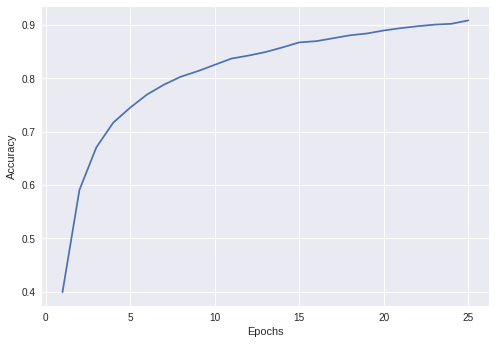

In [0]:
plt.plot(range(1,26), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [31]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving helper.py to helper.py


In [0]:
from helper import get_class_names, get_train_data, get_test_data, plot_images
from helper import plot_model, predict_classes, visualize_errors

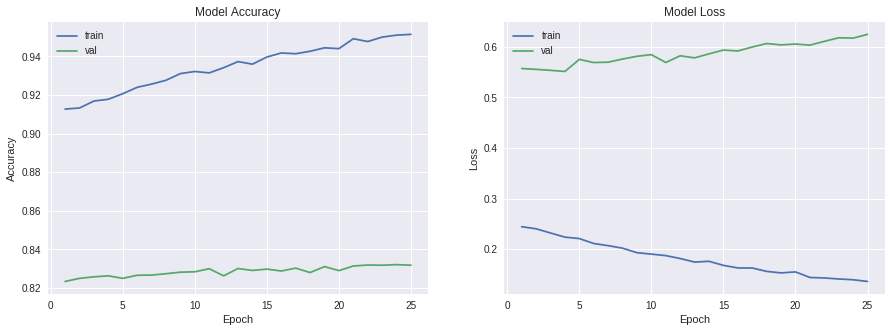

In [0]:
plot_model(modeldetais)

3rd Model

In [0]:
from keras import regularizers

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate



# Create the model
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32),kernel_regularizer=regularizers.l2(weight_decay), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))



#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

# Compile model
epochs = 50

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        18496     
__________

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [0]:
# Fit the model
modeldetais = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=125, batch_size=64,callbacks=[history])

Train on 40000 samples, validate on 10000 samples
Epoch 1/125
20160/40000 [==============>...............] - ETA: 17s - loss: 2.3011 - acc: 0.2810

40000/40000 [==============================] - 37s 914us/step - loss: 1.9229 - acc: 0.3682 - val_loss: 1.3551 - val_acc: 0.5334
Epoch 2/125
40000/40000 [==============================] - 27s 675us/step - loss: 1.2348 - acc: 0.5801 - val_loss: 1.0636 - val_acc: 0.6428
Epoch 3/125
 1344/40000 [>.............................] - ETA: 24s - loss: 1.0146 - acc: 0.6741

40000/40000 [==============================] - 27s 680us/step - loss: 1.0185 - acc: 0.6648 - val_loss: 1.0961 - val_acc: 0.6479
Epoch 4/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.8987 - acc: 0.7132 - val_loss: 0.8812 - val_acc: 0.7262
Epoch 5/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.8625 - acc: 0.7359

40000/40000 [==============================] - 27s 681us/step - loss: 0.8246 - acc: 0.7429 - val_loss: 0.8619 - val_acc: 0.7314
Epoch 6/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.7700 - acc: 0.7644 - val_loss: 0.7386 - val_acc: 0.7769
Epoch 7/125
 1472/40000 [>.............................] - ETA: 24s - loss: 0.7393 - acc: 0.7724

40000/40000 [==============================] - 27s 679us/step - loss: 0.7294 - acc: 0.7813 - val_loss: 0.7686 - val_acc: 0.7721
Epoch 8/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.6971 - acc: 0.7956 - val_loss: 0.7373 - val_acc: 0.7808
Epoch 9/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.6334 - acc: 0.8177

40000/40000 [==============================] - 27s 679us/step - loss: 0.6676 - acc: 0.8054 - val_loss: 0.7289 - val_acc: 0.7958
Epoch 10/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.6438 - acc: 0.8170 - val_loss: 0.6815 - val_acc: 0.8118
Epoch 11/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.6433 - acc: 0.8132

40000/40000 [==============================] - 27s 682us/step - loss: 0.6241 - acc: 0.8270 - val_loss: 0.7003 - val_acc: 0.8049
Epoch 12/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.6043 - acc: 0.8334 - val_loss: 0.7050 - val_acc: 0.8121
Epoch 13/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.5366 - acc: 0.8701

40000/40000 [==============================] - 27s 681us/step - loss: 0.5848 - acc: 0.8429 - val_loss: 0.6810 - val_acc: 0.8149
Epoch 14/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.5742 - acc: 0.8498 - val_loss: 0.7163 - val_acc: 0.8082
Epoch 15/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.5350 - acc: 0.8651

40000/40000 [==============================] - 27s 682us/step - loss: 0.5628 - acc: 0.8535 - val_loss: 0.6602 - val_acc: 0.8268
Epoch 16/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.5496 - acc: 0.8581 - val_loss: 0.6734 - val_acc: 0.8237
Epoch 17/125
 1216/40000 [..............................] - ETA: 25s - loss: 0.4787 - acc: 0.8898

40000/40000 [==============================] - 27s 683us/step - loss: 0.5407 - acc: 0.8650 - val_loss: 0.6820 - val_acc: 0.8242
Epoch 18/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.5328 - acc: 0.8692 - val_loss: 0.6926 - val_acc: 0.8232
Epoch 19/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4773 - acc: 0.8956

40000/40000 [==============================] - 27s 682us/step - loss: 0.5242 - acc: 0.8728 - val_loss: 0.7014 - val_acc: 0.8226
Epoch 20/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.5153 - acc: 0.8763 - val_loss: 0.7081 - val_acc: 0.8247
Epoch 21/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4772 - acc: 0.8898

40000/40000 [==============================] - 27s 681us/step - loss: 0.5092 - acc: 0.8789 - val_loss: 0.7200 - val_acc: 0.8208
Epoch 22/125
40000/40000 [==============================] - 27s 683us/step - loss: 0.5014 - acc: 0.8839 - val_loss: 0.6991 - val_acc: 0.8361
Epoch 23/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4634 - acc: 0.9018

40000/40000 [==============================] - 27s 684us/step - loss: 0.4955 - acc: 0.8858 - val_loss: 0.7354 - val_acc: 0.8204
Epoch 24/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4917 - acc: 0.8885 - val_loss: 0.6996 - val_acc: 0.8333
Epoch 25/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.4460 - acc: 0.9026

40000/40000 [==============================] - 27s 683us/step - loss: 0.4898 - acc: 0.8899 - val_loss: 0.6937 - val_acc: 0.8338
Epoch 26/125
40000/40000 [==============================] - 27s 673us/step - loss: 0.4811 - acc: 0.8943 - val_loss: 0.7191 - val_acc: 0.8283
Epoch 27/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4291 - acc: 0.9137

40000/40000 [==============================] - 27s 681us/step - loss: 0.4828 - acc: 0.8943 - val_loss: 0.6892 - val_acc: 0.8426
Epoch 28/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4751 - acc: 0.8967 - val_loss: 0.7180 - val_acc: 0.8339
Epoch 29/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4715 - acc: 0.8997

40000/40000 [==============================] - 27s 680us/step - loss: 0.4742 - acc: 0.8986 - val_loss: 0.7407 - val_acc: 0.8296
Epoch 30/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.4729 - acc: 0.8990 - val_loss: 0.6996 - val_acc: 0.8423
Epoch 31/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4430 - acc: 0.9077

40000/40000 [==============================] - 27s 681us/step - loss: 0.4689 - acc: 0.9023 - val_loss: 0.7285 - val_acc: 0.8339
Epoch 32/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.4618 - acc: 0.9051 - val_loss: 0.7340 - val_acc: 0.8341
Epoch 33/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4261 - acc: 0.9227

40000/40000 [==============================] - 27s 680us/step - loss: 0.4616 - acc: 0.9049 - val_loss: 0.7168 - val_acc: 0.8390
Epoch 34/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.4602 - acc: 0.9062 - val_loss: 0.7065 - val_acc: 0.8417
Epoch 35/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4233 - acc: 0.9211

40000/40000 [==============================] - 27s 682us/step - loss: 0.4616 - acc: 0.9067 - val_loss: 0.7323 - val_acc: 0.8392
Epoch 36/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4571 - acc: 0.9082 - val_loss: 0.7227 - val_acc: 0.8365
Epoch 37/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4479 - acc: 0.9137

40000/40000 [==============================] - 27s 683us/step - loss: 0.4568 - acc: 0.9107 - val_loss: 0.7203 - val_acc: 0.8436
Epoch 38/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4556 - acc: 0.9092 - val_loss: 0.7171 - val_acc: 0.8382
Epoch 39/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4274 - acc: 0.9087

40000/40000 [==============================] - 27s 682us/step - loss: 0.4490 - acc: 0.9134 - val_loss: 0.7304 - val_acc: 0.8428
Epoch 40/125
40000/40000 [==============================] - 27s 678us/step - loss: 0.4507 - acc: 0.9123 - val_loss: 0.7384 - val_acc: 0.8375
Epoch 41/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4233 - acc: 0.9196

40000/40000 [==============================] - 27s 680us/step - loss: 0.4454 - acc: 0.9136 - val_loss: 0.7786 - val_acc: 0.8252
Epoch 42/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4473 - acc: 0.9141 - val_loss: 0.7190 - val_acc: 0.8365
Epoch 43/125
 1216/40000 [..............................] - ETA: 25s - loss: 0.3950 - acc: 0.9285

40000/40000 [==============================] - 27s 681us/step - loss: 0.4459 - acc: 0.9151 - val_loss: 0.7360 - val_acc: 0.8363
Epoch 44/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4414 - acc: 0.9175 - val_loss: 0.7743 - val_acc: 0.8337
Epoch 45/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3973 - acc: 0.9375

40000/40000 [==============================] - 27s 682us/step - loss: 0.4446 - acc: 0.9146 - val_loss: 0.7169 - val_acc: 0.8460
Epoch 46/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.4360 - acc: 0.9203 - val_loss: 0.7229 - val_acc: 0.8476
Epoch 47/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4097 - acc: 0.9301

40000/40000 [==============================] - 27s 682us/step - loss: 0.4346 - acc: 0.9203 - val_loss: 0.7385 - val_acc: 0.8377
Epoch 48/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4352 - acc: 0.9199 - val_loss: 0.7423 - val_acc: 0.8357
Epoch 49/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4157 - acc: 0.9353

40000/40000 [==============================] - 27s 680us/step - loss: 0.4372 - acc: 0.9196 - val_loss: 0.7377 - val_acc: 0.8417
Epoch 50/125
40000/40000 [==============================] - 27s 673us/step - loss: 0.4349 - acc: 0.9206 - val_loss: 0.7605 - val_acc: 0.8365
Epoch 51/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4120 - acc: 0.9345

40000/40000 [==============================] - 27s 682us/step - loss: 0.4347 - acc: 0.9211 - val_loss: 0.7297 - val_acc: 0.8399
Epoch 52/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.4393 - acc: 0.9190 - val_loss: 0.7584 - val_acc: 0.8376
Epoch 53/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3991 - acc: 0.9293

40000/40000 [==============================] - 27s 680us/step - loss: 0.4371 - acc: 0.9204 - val_loss: 0.7349 - val_acc: 0.8432
Epoch 54/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.4301 - acc: 0.9223 - val_loss: 0.7323 - val_acc: 0.8448
Epoch 55/125
 1344/40000 [>.............................] - ETA: 25s - loss: 0.3766 - acc: 0.9390

40000/40000 [==============================] - 27s 682us/step - loss: 0.4274 - acc: 0.9247 - val_loss: 0.7347 - val_acc: 0.8416
Epoch 56/125
40000/40000 [==============================] - 27s 678us/step - loss: 0.4275 - acc: 0.9235 - val_loss: 0.7233 - val_acc: 0.8485
Epoch 57/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4075 - acc: 0.9345

40000/40000 [==============================] - 27s 677us/step - loss: 0.4283 - acc: 0.9248 - val_loss: 0.7349 - val_acc: 0.8444
Epoch 58/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.4271 - acc: 0.9216 - val_loss: 0.7464 - val_acc: 0.8417
Epoch 59/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3905 - acc: 0.9391

40000/40000 [==============================] - 27s 682us/step - loss: 0.4299 - acc: 0.9245 - val_loss: 0.7556 - val_acc: 0.8376
Epoch 60/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.4247 - acc: 0.9263 - val_loss: 0.7507 - val_acc: 0.8379
Epoch 61/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4018 - acc: 0.9359

40000/40000 [==============================] - 27s 677us/step - loss: 0.4280 - acc: 0.9241 - val_loss: 0.7386 - val_acc: 0.8387
Epoch 62/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.4231 - acc: 0.9265 - val_loss: 0.7170 - val_acc: 0.8487
Epoch 63/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3765 - acc: 0.9465

40000/40000 [==============================] - 27s 682us/step - loss: 0.4212 - acc: 0.9270 - val_loss: 0.7355 - val_acc: 0.8403
Epoch 64/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.4223 - acc: 0.9269 - val_loss: 0.7226 - val_acc: 0.8477
Epoch 65/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3660 - acc: 0.9449

40000/40000 [==============================] - 27s 681us/step - loss: 0.4201 - acc: 0.9278 - val_loss: 0.7296 - val_acc: 0.8447
Epoch 66/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.4186 - acc: 0.9269 - val_loss: 0.7522 - val_acc: 0.8428
Epoch 67/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4244 - acc: 0.9308

40000/40000 [==============================] - 27s 683us/step - loss: 0.4182 - acc: 0.9274 - val_loss: 0.7376 - val_acc: 0.8458
Epoch 68/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4184 - acc: 0.9278 - val_loss: 0.7300 - val_acc: 0.8502
Epoch 69/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.4091 - acc: 0.9286

40000/40000 [==============================] - 27s 681us/step - loss: 0.4201 - acc: 0.9274 - val_loss: 0.7192 - val_acc: 0.8483
Epoch 70/125
40000/40000 [==============================] - 27s 683us/step - loss: 0.4169 - acc: 0.9282 - val_loss: 0.7478 - val_acc: 0.8431
Epoch 71/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3703 - acc: 0.9442

40000/40000 [==============================] - 27s 681us/step - loss: 0.4198 - acc: 0.9273 - val_loss: 0.7504 - val_acc: 0.8433
Epoch 72/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4188 - acc: 0.9286 - val_loss: 0.7296 - val_acc: 0.8455
Epoch 73/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4010 - acc: 0.9309

40000/40000 [==============================] - 27s 680us/step - loss: 0.4147 - acc: 0.9297 - val_loss: 0.7260 - val_acc: 0.8438
Epoch 74/125
40000/40000 [==============================] - 27s 671us/step - loss: 0.4111 - acc: 0.9304 - val_loss: 0.7196 - val_acc: 0.8535
Epoch 75/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3776 - acc: 0.9375

40000/40000 [==============================] - 27s 685us/step - loss: 0.4111 - acc: 0.9310 - val_loss: 0.7304 - val_acc: 0.8433
Epoch 76/125
40000/40000 [==============================] - 27s 685us/step - loss: 0.4105 - acc: 0.9307 - val_loss: 0.7168 - val_acc: 0.8501
Epoch 77/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3753 - acc: 0.9424

40000/40000 [==============================] - 27s 683us/step - loss: 0.4127 - acc: 0.9317 - val_loss: 0.7326 - val_acc: 0.8456
Epoch 78/125
40000/40000 [==============================] - 27s 684us/step - loss: 0.4103 - acc: 0.9316 - val_loss: 0.7399 - val_acc: 0.8472
Epoch 79/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.4031 - acc: 0.9293

40000/40000 [==============================] - 27s 680us/step - loss: 0.4101 - acc: 0.9310 - val_loss: 0.7391 - val_acc: 0.8498
Epoch 80/125
40000/40000 [==============================] - 27s 683us/step - loss: 0.4149 - acc: 0.9296 - val_loss: 0.7484 - val_acc: 0.8455
Epoch 81/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3948 - acc: 0.9375

40000/40000 [==============================] - 27s 682us/step - loss: 0.4062 - acc: 0.9337 - val_loss: 0.7317 - val_acc: 0.8527
Epoch 82/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4064 - acc: 0.9326 - val_loss: 0.7284 - val_acc: 0.8534
Epoch 83/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3681 - acc: 0.9435

40000/40000 [==============================] - 27s 681us/step - loss: 0.4076 - acc: 0.9330 - val_loss: 0.7455 - val_acc: 0.8471
Epoch 84/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4054 - acc: 0.9330 - val_loss: 0.7237 - val_acc: 0.8498
Epoch 85/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3870 - acc: 0.9427

40000/40000 [==============================] - 27s 682us/step - loss: 0.4044 - acc: 0.9330 - val_loss: 0.7390 - val_acc: 0.8498
Epoch 86/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4113 - acc: 0.9304 - val_loss: 0.7096 - val_acc: 0.8537
Epoch 87/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3696 - acc: 0.9412

40000/40000 [==============================] - 27s 677us/step - loss: 0.4014 - acc: 0.9352 - val_loss: 0.7477 - val_acc: 0.8527
Epoch 88/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4012 - acc: 0.9342 - val_loss: 0.7276 - val_acc: 0.8558
Epoch 89/125
 1344/40000 [>.............................] - ETA: 24s - loss: 0.3621 - acc: 0.9479

40000/40000 [==============================] - 27s 680us/step - loss: 0.4032 - acc: 0.9322 - val_loss: 0.7667 - val_acc: 0.8455
Epoch 90/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.4010 - acc: 0.9330 - val_loss: 0.7645 - val_acc: 0.8450
Epoch 91/125
 1344/40000 [>.............................] - ETA: 25s - loss: 0.3730 - acc: 0.9472

40000/40000 [==============================] - 27s 681us/step - loss: 0.3992 - acc: 0.9363 - val_loss: 0.7292 - val_acc: 0.8486
Epoch 92/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4014 - acc: 0.9356 - val_loss: 0.7236 - val_acc: 0.8500
Epoch 93/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3702 - acc: 0.9482

40000/40000 [==============================] - 27s 680us/step - loss: 0.4016 - acc: 0.9355 - val_loss: 0.7194 - val_acc: 0.8531
Epoch 94/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.4001 - acc: 0.9340 - val_loss: 0.7162 - val_acc: 0.8494
Epoch 95/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3646 - acc: 0.9465

40000/40000 [==============================] - 27s 681us/step - loss: 0.4025 - acc: 0.9342 - val_loss: 0.7044 - val_acc: 0.8582
Epoch 96/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.3995 - acc: 0.9356 - val_loss: 0.7051 - val_acc: 0.8525
Epoch 97/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3768 - acc: 0.9383

40000/40000 [==============================] - 27s 680us/step - loss: 0.3959 - acc: 0.9353 - val_loss: 0.7293 - val_acc: 0.8557
Epoch 98/125
40000/40000 [==============================] - 27s 672us/step - loss: 0.3958 - acc: 0.9350 - val_loss: 0.7263 - val_acc: 0.8541
Epoch 99/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3740 - acc: 0.9416

40000/40000 [==============================] - 27s 680us/step - loss: 0.4004 - acc: 0.9342 - val_loss: 0.7218 - val_acc: 0.8490
Epoch 100/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.3965 - acc: 0.9364 - val_loss: 0.7412 - val_acc: 0.8472
Epoch 101/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3656 - acc: 0.9476

40000/40000 [==============================] - 27s 678us/step - loss: 0.3978 - acc: 0.9358 - val_loss: 0.7365 - val_acc: 0.8474
Epoch 102/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.3991 - acc: 0.9348 - val_loss: 0.7119 - val_acc: 0.8531
Epoch 103/125
  960/40000 [..............................] - ETA: 24s - loss: 0.3725 - acc: 0.9344

40000/40000 [==============================] - 27s 680us/step - loss: 0.3987 - acc: 0.9346 - val_loss: 0.7125 - val_acc: 0.8498
Epoch 104/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.3907 - acc: 0.9369 - val_loss: 0.7187 - val_acc: 0.8509
Epoch 105/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3817 - acc: 0.9366

40000/40000 [==============================] - 27s 681us/step - loss: 0.3947 - acc: 0.9351 - val_loss: 0.7229 - val_acc: 0.8577
Epoch 106/125
40000/40000 [==============================] - 27s 683us/step - loss: 0.3955 - acc: 0.9358 - val_loss: 0.7062 - val_acc: 0.8538
Epoch 107/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3493 - acc: 0.9494

40000/40000 [==============================] - 27s 680us/step - loss: 0.3931 - acc: 0.9373 - val_loss: 0.7260 - val_acc: 0.8536
Epoch 108/125
40000/40000 [==============================] - 27s 682us/step - loss: 0.3971 - acc: 0.9344 - val_loss: 0.7231 - val_acc: 0.8547
Epoch 109/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3757 - acc: 0.9449

40000/40000 [==============================] - 27s 684us/step - loss: 0.3894 - acc: 0.9375 - val_loss: 0.7139 - val_acc: 0.8564
Epoch 110/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.3890 - acc: 0.9383 - val_loss: 0.7207 - val_acc: 0.8565
Epoch 111/125
 1152/40000 [..............................] - ETA: 25s - loss: 0.3857 - acc: 0.9410

40000/40000 [==============================] - 27s 682us/step - loss: 0.3880 - acc: 0.9382 - val_loss: 0.7239 - val_acc: 0.8516
Epoch 112/125
40000/40000 [==============================] - 27s 677us/step - loss: 0.3893 - acc: 0.9395 - val_loss: 0.7013 - val_acc: 0.8553
Epoch 113/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3474 - acc: 0.9504

40000/40000 [==============================] - 27s 682us/step - loss: 0.3852 - acc: 0.9395 - val_loss: 0.7209 - val_acc: 0.8551
Epoch 114/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.3937 - acc: 0.9362 - val_loss: 0.7429 - val_acc: 0.8503
Epoch 115/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3560 - acc: 0.9474

40000/40000 [==============================] - 27s 682us/step - loss: 0.3898 - acc: 0.9373 - val_loss: 0.7259 - val_acc: 0.8561
Epoch 116/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.3907 - acc: 0.9372 - val_loss: 0.7497 - val_acc: 0.8481
Epoch 117/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3655 - acc: 0.9504

40000/40000 [==============================] - 27s 679us/step - loss: 0.3939 - acc: 0.9372 - val_loss: 0.7136 - val_acc: 0.8514
Epoch 118/125
40000/40000 [==============================] - 27s 681us/step - loss: 0.3877 - acc: 0.9392 - val_loss: 0.7408 - val_acc: 0.8474
Epoch 119/125
 1088/40000 [..............................] - ETA: 25s - loss: 0.3620 - acc: 0.9430

40000/40000 [==============================] - 27s 682us/step - loss: 0.3865 - acc: 0.9383 - val_loss: 0.7455 - val_acc: 0.8525
Epoch 120/125
40000/40000 [==============================] - 27s 683us/step - loss: 0.3852 - acc: 0.9395 - val_loss: 0.7265 - val_acc: 0.8545
Epoch 121/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3923 - acc: 0.9366

40000/40000 [==============================] - 27s 674us/step - loss: 0.3829 - acc: 0.9398 - val_loss: 0.7407 - val_acc: 0.8505
Epoch 122/125
40000/40000 [==============================] - 27s 679us/step - loss: 0.3871 - acc: 0.9394 - val_loss: 0.6979 - val_acc: 0.8580
Epoch 123/125
 1216/40000 [..............................] - ETA: 24s - loss: 0.3746 - acc: 0.9400

40000/40000 [==============================] - 27s 680us/step - loss: 0.3827 - acc: 0.9410 - val_loss: 0.7573 - val_acc: 0.8449
Epoch 124/125
40000/40000 [==============================] - 27s 680us/step - loss: 0.3863 - acc: 0.9396 - val_loss: 0.7118 - val_acc: 0.8599
Epoch 125/125
 1088/40000 [..............................] - ETA: 24s - loss: 0.3596 - acc: 0.9467

40000/40000 [==============================] - 27s 682us/step - loss: 0.3841 - acc: 0.9399 - val_loss: 0.7137 - val_acc: 0.8590


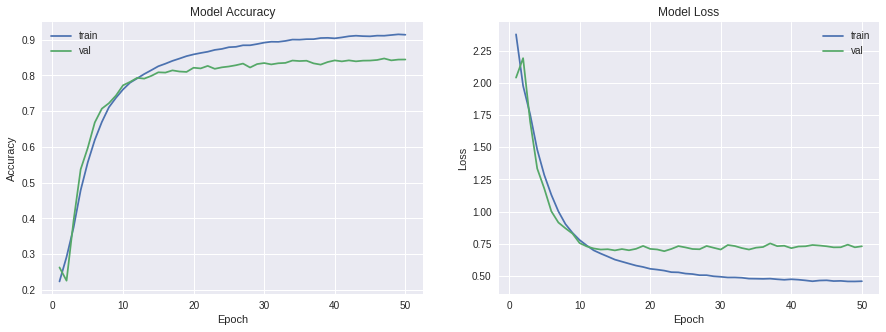

In [0]:
plot_model(modeldetais)

lets plot the same model with 125 epochs.


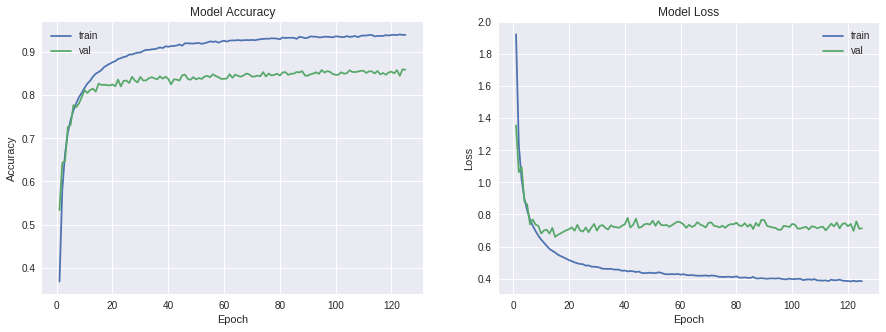

In [0]:
plot_model(modeldetais)

The accurarcy is fixed at 85% only. the model needs more improvement.

4th Model

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate



# Create the model
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32),kernel_regularizer=regularizers.l2(weight_decay), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

# Compile model
epochs = 50
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 64, 16, 16)        18496     
__________

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [0]:
model4 = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=64,callbacks=[history])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 44s 1ms/step - loss: 1.8589 - acc: 0.3759 - val_loss: 1.3028 - val_acc: 0.5416
Epoch 2/50
 2240/40000 [>.............................] - ETA: 31s - loss: 1.3570 - acc: 0.5254

40000/40000 [==============================] - 39s 972us/step - loss: 1.2081 - acc: 0.5829 - val_loss: 1.0243 - val_acc: 0.6633
Epoch 3/50
15872/40000 [==========>...................] - ETA: 19s - loss: 1.0332 - acc: 0.6525

40000/40000 [==============================] - 34s 852us/step - loss: 0.9980 - acc: 0.6653 - val_loss: 0.8948 - val_acc: 0.7059
Epoch 4/50
26880/40000 [===================>..........] - ETA: 10s - loss: 0.8832 - acc: 0.7126

40000/40000 [==============================] - 33s 824us/step - loss: 0.8778 - acc: 0.7141 - val_loss: 0.7764 - val_acc: 0.7500
Epoch 5/50
40000/40000 [==============================] - 31s 787us/step - loss: 0.8005 - acc: 0.7417 - val_loss: 0.7554 - val_acc: 0.7651
Epoch 6/50
 2560/40000 [>.............................] - ETA: 27s - loss: 0.7218 - acc: 0.7762

40000/40000 [==============================] - 31s 775us/step - loss: 0.7466 - acc: 0.7674 - val_loss: 0.7274 - val_acc: 0.7731
Epoch 7/50
38528/40000 [===========================>..] - ETA: 1s - loss: 0.6973 - acc: 0.7860

40000/40000 [==============================] - 31s 778us/step - loss: 0.6963 - acc: 0.7865 - val_loss: 0.7076 - val_acc: 0.7862
Epoch 8/50
40000/40000 [==============================] - 31s 779us/step - loss: 0.6641 - acc: 0.8005 - val_loss: 0.7157 - val_acc: 0.7863
Epoch 9/50
 6592/40000 [===>..........................] - ETA: 24s - loss: 0.6054 - acc: 0.8258

40000/40000 [==============================] - 31s 777us/step - loss: 0.6447 - acc: 0.8123 - val_loss: 0.6882 - val_acc: 0.8022
Epoch 10/50
40000/40000 [==============================] - 31s 765us/step - loss: 0.6183 - acc: 0.8216 - val_loss: 0.6856 - val_acc: 0.8039
Epoch 11/50
  704/40000 [..............................] - ETA: 27s - loss: 0.5808 - acc: 0.8537

40000/40000 [==============================] - 31s 764us/step - loss: 0.5966 - acc: 0.8314 - val_loss: 0.7308 - val_acc: 0.7979
Epoch 12/50
39296/40000 [============================>.] - ETA: 0s - loss: 0.5848 - acc: 0.8409

40000/40000 [==============================] - 31s 765us/step - loss: 0.5860 - acc: 0.8404 - val_loss: 0.6649 - val_acc: 0.8166
Epoch 13/50
40000/40000 [==============================] - 30s 750us/step - loss: 0.5725 - acc: 0.8460 - val_loss: 0.6829 - val_acc: 0.8151
Epoch 14/50
 9216/40000 [=====>........................] - ETA: 21s - loss: 0.5162 - acc: 0.8684

40000/40000 [==============================] - 30s 748us/step - loss: 0.5591 - acc: 0.8532 - val_loss: 0.6900 - val_acc: 0.8160
Epoch 15/50
40000/40000 [==============================] - 29s 728us/step - loss: 0.5477 - acc: 0.8582 - val_loss: 0.6837 - val_acc: 0.8181
Epoch 16/50
 2624/40000 [>.............................] - ETA: 25s - loss: 0.4891 - acc: 0.8822

40000/40000 [==============================] - 29s 727us/step - loss: 0.5400 - acc: 0.8626 - val_loss: 0.6931 - val_acc: 0.8210
Epoch 17/50
40000/40000 [==============================] - 28s 711us/step - loss: 0.5298 - acc: 0.8680 - val_loss: 0.6870 - val_acc: 0.8271
Epoch 18/50
 1472/40000 [>.............................] - ETA: 25s - loss: 0.4818 - acc: 0.8811

40000/40000 [==============================] - 28s 707us/step - loss: 0.5217 - acc: 0.8718 - val_loss: 0.6905 - val_acc: 0.8257
Epoch 19/50
40000/40000 [==============================] - 28s 711us/step - loss: 0.5194 - acc: 0.8724 - val_loss: 0.7215 - val_acc: 0.8196
Epoch 20/50
  960/40000 [..............................] - ETA: 26s - loss: 0.4666 - acc: 0.8844

40000/40000 [==============================] - 28s 711us/step - loss: 0.5115 - acc: 0.8780 - val_loss: 0.6792 - val_acc: 0.8326
Epoch 21/50
40000/40000 [==============================] - 28s 708us/step - loss: 0.5048 - acc: 0.8829 - val_loss: 0.7128 - val_acc: 0.8276
Epoch 22/50
 1088/40000 [..............................] - ETA: 25s - loss: 0.4471 - acc: 0.9035

40000/40000 [==============================] - 28s 709us/step - loss: 0.4965 - acc: 0.8862 - val_loss: 0.6850 - val_acc: 0.8353
Epoch 23/50
40000/40000 [==============================] - 28s 708us/step - loss: 0.4963 - acc: 0.8864 - val_loss: 0.6993 - val_acc: 0.8366
Epoch 24/50
  896/40000 [..............................] - ETA: 25s - loss: 0.4714 - acc: 0.8996

40000/40000 [==============================] - 28s 695us/step - loss: 0.4891 - acc: 0.8893 - val_loss: 0.6864 - val_acc: 0.8348
Epoch 25/50
40000/40000 [==============================] - 28s 695us/step - loss: 0.4873 - acc: 0.8923 - val_loss: 0.7281 - val_acc: 0.8255
Epoch 26/50
 1216/40000 [..............................] - ETA: 24s - loss: 0.4672 - acc: 0.9030

40000/40000 [==============================] - 28s 698us/step - loss: 0.4812 - acc: 0.8959 - val_loss: 0.6984 - val_acc: 0.8390
Epoch 27/50
40000/40000 [==============================] - 28s 695us/step - loss: 0.4741 - acc: 0.8986 - val_loss: 0.6940 - val_acc: 0.8408
Epoch 28/50
 1152/40000 [..............................] - ETA: 25s - loss: 0.4266 - acc: 0.9167

40000/40000 [==============================] - 28s 697us/step - loss: 0.4703 - acc: 0.9002 - val_loss: 0.7193 - val_acc: 0.8353
Epoch 29/50
40000/40000 [==============================] - 28s 693us/step - loss: 0.4725 - acc: 0.9013 - val_loss: 0.7016 - val_acc: 0.8434
Epoch 30/50
 1280/40000 [..............................] - ETA: 25s - loss: 0.4211 - acc: 0.9211

40000/40000 [==============================] - 28s 695us/step - loss: 0.4646 - acc: 0.9050 - val_loss: 0.7178 - val_acc: 0.8397
Epoch 31/50
40000/40000 [==============================] - 28s 694us/step - loss: 0.4661 - acc: 0.9052 - val_loss: 0.7319 - val_acc: 0.8358
Epoch 32/50
 1216/40000 [..............................] - ETA: 25s - loss: 0.4639 - acc: 0.9071

40000/40000 [==============================] - 28s 698us/step - loss: 0.4635 - acc: 0.9072 - val_loss: 0.7345 - val_acc: 0.8332
Epoch 33/50
40000/40000 [==============================] - 28s 695us/step - loss: 0.4617 - acc: 0.9071 - val_loss: 0.7306 - val_acc: 0.8387
Epoch 34/50
 1216/40000 [..............................] - ETA: 25s - loss: 0.4182 - acc: 0.9309

40000/40000 [==============================] - 28s 696us/step - loss: 0.4571 - acc: 0.9097 - val_loss: 0.7324 - val_acc: 0.8372
Epoch 35/50
40000/40000 [==============================] - 28s 696us/step - loss: 0.4552 - acc: 0.9108 - val_loss: 0.7330 - val_acc: 0.8381
Epoch 36/50
 1216/40000 [..............................] - ETA: 25s - loss: 0.4278 - acc: 0.9219

40000/40000 [==============================] - 28s 696us/step - loss: 0.4557 - acc: 0.9120 - val_loss: 0.7315 - val_acc: 0.8391
Epoch 37/50
40000/40000 [==============================] - 28s 696us/step - loss: 0.4521 - acc: 0.9122 - val_loss: 0.7153 - val_acc: 0.8453
Epoch 38/50
 1344/40000 [>.............................] - ETA: 25s - loss: 0.4266 - acc: 0.9226

40000/40000 [==============================] - 28s 696us/step - loss: 0.4478 - acc: 0.9134 - val_loss: 0.7299 - val_acc: 0.8414
Epoch 39/50
40000/40000 [==============================] - 28s 696us/step - loss: 0.4504 - acc: 0.9140 - val_loss: 0.7592 - val_acc: 0.8305
Epoch 40/50
 1216/40000 [..............................] - ETA: 24s - loss: 0.4345 - acc: 0.9153

40000/40000 [==============================] - 28s 695us/step - loss: 0.4502 - acc: 0.9143 - val_loss: 0.7225 - val_acc: 0.8413
Epoch 41/50
40000/40000 [==============================] - 28s 695us/step - loss: 0.4429 - acc: 0.9166 - val_loss: 0.7426 - val_acc: 0.8390
Epoch 42/50
 1088/40000 [..............................] - ETA: 25s - loss: 0.4348 - acc: 0.9219

40000/40000 [==============================] - 28s 697us/step - loss: 0.4474 - acc: 0.9165 - val_loss: 0.7119 - val_acc: 0.8469
Epoch 43/50
40000/40000 [==============================] - 28s 698us/step - loss: 0.4431 - acc: 0.9190 - val_loss: 0.7241 - val_acc: 0.8449
Epoch 44/50
 1216/40000 [..............................] - ETA: 24s - loss: 0.4183 - acc: 0.9235

40000/40000 [==============================] - 28s 694us/step - loss: 0.4472 - acc: 0.9167 - val_loss: 0.7365 - val_acc: 0.8432
Epoch 45/50
40000/40000 [==============================] - 28s 697us/step - loss: 0.4411 - acc: 0.9195 - val_loss: 0.7149 - val_acc: 0.8470
Epoch 46/50
 1088/40000 [..............................] - ETA: 25s - loss: 0.4316 - acc: 0.9154

40000/40000 [==============================] - 28s 694us/step - loss: 0.4403 - acc: 0.9190 - val_loss: 0.7438 - val_acc: 0.8432
Epoch 47/50
40000/40000 [==============================] - 28s 698us/step - loss: 0.4437 - acc: 0.9171 - val_loss: 0.7435 - val_acc: 0.8480
Epoch 48/50
 1216/40000 [..............................] - ETA: 24s - loss: 0.4290 - acc: 0.9194

40000/40000 [==============================] - 28s 697us/step - loss: 0.4438 - acc: 0.9195 - val_loss: 0.7537 - val_acc: 0.8417
Epoch 49/50
40000/40000 [==============================] - 28s 697us/step - loss: 0.4343 - acc: 0.9225 - val_loss: 0.7256 - val_acc: 0.8495
Epoch 50/50
 1216/40000 [..............................] - ETA: 24s - loss: 0.3970 - acc: 0.9326

40000/40000 [==============================] - 28s 696us/step - loss: 0.4393 - acc: 0.9197 - val_loss: 0.7336 - val_acc: 0.8437


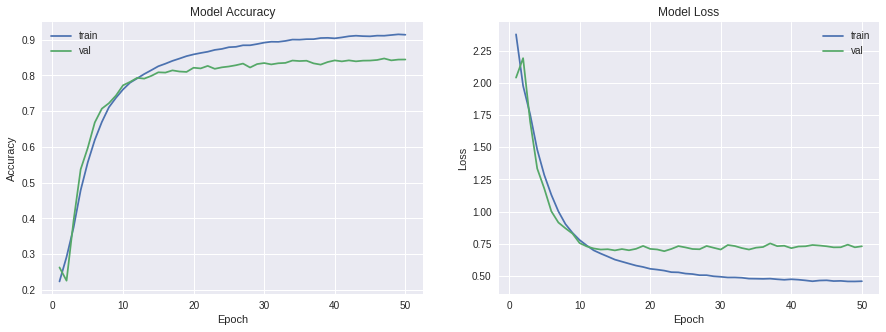

In [0]:
plot_model(modeldetais)

the result is still the same.

5th Model

In [26]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate



# Create the model
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32),kernel_regularizer=regularizers.l2(weight_decay), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))



#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

nadam=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 16, 16)        18496     
__________

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

In [28]:
model5 = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=125, batch_size=64,callbacks=[history])

Train on 40000 samples, validate on 10000 samples
Epoch 1/125
40000/40000 [==============================] - 44s 1ms/step - loss: 1.8165 - acc: 0.3996 - val_loss: 1.2401 - val_acc: 0.5596
Epoch 2/125
 1216/40000 [..............................] - ETA: 26s - loss: 1.2649 - acc: 0.5600

40000/40000 [==============================] - 28s 709us/step - loss: 1.1301 - acc: 0.6167 - val_loss: 0.9658 - val_acc: 0.6800
Epoch 3/125
40000/40000 [==============================] - 28s 706us/step - loss: 0.9089 - acc: 0.7004 - val_loss: 0.8185 - val_acc: 0.7311
Epoch 4/125
  576/40000 [..............................] - ETA: 25s - loss: 0.7613 - acc: 0.7431

40000/40000 [==============================] - 28s 702us/step - loss: 0.8036 - acc: 0.7399 - val_loss: 0.7948 - val_acc: 0.7483
Epoch 5/125
40000/40000 [==============================] - 28s 700us/step - loss: 0.7338 - acc: 0.7666 - val_loss: 0.6807 - val_acc: 0.7864
Epoch 6/125
  832/40000 [..............................] - ETA: 25s - loss: 0.7136 - acc: 0.7885

40000/40000 [==============================] - 28s 701us/step - loss: 0.6844 - acc: 0.7856 - val_loss: 0.6724 - val_acc: 0.7994
Epoch 7/125
40000/40000 [==============================] - 28s 702us/step - loss: 0.6488 - acc: 0.8034 - val_loss: 0.6740 - val_acc: 0.8012
Epoch 8/125
  320/40000 [..............................] - ETA: 25s - loss: 0.6574 - acc: 0.7969

40000/40000 [==============================] - 28s 704us/step - loss: 0.6180 - acc: 0.8163 - val_loss: 0.6647 - val_acc: 0.8034
Epoch 9/125
40000/40000 [==============================] - 28s 705us/step - loss: 0.5979 - acc: 0.8246 - val_loss: 0.6523 - val_acc: 0.8091
Epoch 10/125
  192/40000 [..............................] - ETA: 26s - loss: 0.5006 - acc: 0.8490

40000/40000 [==============================] - 28s 705us/step - loss: 0.5710 - acc: 0.8413 - val_loss: 0.6825 - val_acc: 0.8067
Epoch 11/125
40000/40000 [==============================] - 28s 701us/step - loss: 0.5625 - acc: 0.8418 - val_loss: 0.6223 - val_acc: 0.8280
Epoch 12/125
  192/40000 [..............................] - ETA: 25s - loss: 0.4608 - acc: 0.8750

40000/40000 [==============================] - 28s 700us/step - loss: 0.5486 - acc: 0.8495 - val_loss: 0.6450 - val_acc: 0.8259
Epoch 13/125
40000/40000 [==============================] - 28s 705us/step - loss: 0.5369 - acc: 0.8553 - val_loss: 0.6438 - val_acc: 0.8272
Epoch 14/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4459 - acc: 0.8929

40000/40000 [==============================] - 28s 707us/step - loss: 0.5224 - acc: 0.8646 - val_loss: 0.6511 - val_acc: 0.8298
Epoch 15/125
40000/40000 [==============================] - 28s 709us/step - loss: 0.5145 - acc: 0.8672 - val_loss: 0.6520 - val_acc: 0.8294
Epoch 16/125
  192/40000 [..............................] - ETA: 26s - loss: 0.4324 - acc: 0.9115

40000/40000 [==============================] - 28s 704us/step - loss: 0.5032 - acc: 0.8736 - val_loss: 0.6641 - val_acc: 0.8326
Epoch 17/125
40000/40000 [==============================] - 28s 708us/step - loss: 0.5002 - acc: 0.8765 - val_loss: 0.6505 - val_acc: 0.8370
Epoch 18/125
  192/40000 [..............................] - ETA: 26s - loss: 0.4706 - acc: 0.8906

40000/40000 [==============================] - 28s 706us/step - loss: 0.4917 - acc: 0.8802 - val_loss: 0.7001 - val_acc: 0.8263
Epoch 19/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4903 - acc: 0.8829 - val_loss: 0.6590 - val_acc: 0.8369
Epoch 20/125
   64/40000 [..............................] - ETA: 29s - loss: 0.4731 - acc: 0.8906

40000/40000 [==============================] - 28s 705us/step - loss: 0.4835 - acc: 0.8884 - val_loss: 0.6460 - val_acc: 0.8427
Epoch 21/125
40000/40000 [==============================] - 28s 708us/step - loss: 0.4798 - acc: 0.8887 - val_loss: 0.6575 - val_acc: 0.8391
Epoch 22/125
  576/40000 [..............................] - ETA: 26s - loss: 0.4419 - acc: 0.9062

40000/40000 [==============================] - 28s 709us/step - loss: 0.4751 - acc: 0.8908 - val_loss: 0.6489 - val_acc: 0.8487
Epoch 23/125
40000/40000 [==============================] - 28s 704us/step - loss: 0.4682 - acc: 0.8965 - val_loss: 0.7122 - val_acc: 0.8334
Epoch 24/125
  448/40000 [..............................] - ETA: 26s - loss: 0.4188 - acc: 0.9040

40000/40000 [==============================] - 28s 708us/step - loss: 0.4703 - acc: 0.8958 - val_loss: 0.6982 - val_acc: 0.8332
Epoch 25/125
40000/40000 [==============================] - 28s 708us/step - loss: 0.4658 - acc: 0.8988 - val_loss: 0.6772 - val_acc: 0.8446
Epoch 26/125
  576/40000 [..............................] - ETA: 25s - loss: 0.3881 - acc: 0.9358

40000/40000 [==============================] - 28s 710us/step - loss: 0.4623 - acc: 0.9014 - val_loss: 0.6730 - val_acc: 0.8472
Epoch 27/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4609 - acc: 0.9032 - val_loss: 0.7115 - val_acc: 0.8336
Epoch 28/125
  448/40000 [..............................] - ETA: 27s - loss: 0.4573 - acc: 0.9085

40000/40000 [==============================] - 28s 708us/step - loss: 0.4591 - acc: 0.9040 - val_loss: 0.6707 - val_acc: 0.8456
Epoch 29/125
40000/40000 [==============================] - 28s 702us/step - loss: 0.4533 - acc: 0.9077 - val_loss: 0.6962 - val_acc: 0.8439
Epoch 30/125
  448/40000 [..............................] - ETA: 26s - loss: 0.4280 - acc: 0.8906

40000/40000 [==============================] - 28s 703us/step - loss: 0.4532 - acc: 0.9075 - val_loss: 0.6986 - val_acc: 0.8440
Epoch 31/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4488 - acc: 0.9103 - val_loss: 0.6909 - val_acc: 0.8454
Epoch 32/125
  320/40000 [..............................] - ETA: 26s - loss: 0.4168 - acc: 0.9219

40000/40000 [==============================] - 28s 708us/step - loss: 0.4516 - acc: 0.9092 - val_loss: 0.6943 - val_acc: 0.8468
Epoch 33/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4478 - acc: 0.9112 - val_loss: 0.7011 - val_acc: 0.8434
Epoch 34/125
  448/40000 [..............................] - ETA: 26s - loss: 0.4304 - acc: 0.9196

40000/40000 [==============================] - 28s 701us/step - loss: 0.4487 - acc: 0.9117 - val_loss: 0.7073 - val_acc: 0.8409
Epoch 35/125
40000/40000 [==============================] - 28s 705us/step - loss: 0.4391 - acc: 0.9140 - val_loss: 0.6968 - val_acc: 0.8544
Epoch 36/125
  704/40000 [..............................] - ETA: 25s - loss: 0.4528 - acc: 0.9062

40000/40000 [==============================] - 28s 700us/step - loss: 0.4429 - acc: 0.9145 - val_loss: 0.6845 - val_acc: 0.8530
Epoch 37/125
40000/40000 [==============================] - 28s 701us/step - loss: 0.4423 - acc: 0.9142 - val_loss: 0.7193 - val_acc: 0.8417
Epoch 38/125
  704/40000 [..............................] - ETA: 26s - loss: 0.4594 - acc: 0.9077

40000/40000 [==============================] - 28s 700us/step - loss: 0.4369 - acc: 0.9184 - val_loss: 0.7103 - val_acc: 0.8465
Epoch 39/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4383 - acc: 0.9174 - val_loss: 0.7199 - val_acc: 0.8482
Epoch 40/125
  704/40000 [..............................] - ETA: 25s - loss: 0.3975 - acc: 0.9276

40000/40000 [==============================] - 28s 705us/step - loss: 0.4403 - acc: 0.9174 - val_loss: 0.7233 - val_acc: 0.8481
Epoch 41/125
40000/40000 [==============================] - 28s 708us/step - loss: 0.4348 - acc: 0.9186 - val_loss: 0.7054 - val_acc: 0.8480
Epoch 42/125
  576/40000 [..............................] - ETA: 26s - loss: 0.4189 - acc: 0.9271

40000/40000 [==============================] - 28s 710us/step - loss: 0.4397 - acc: 0.9177 - val_loss: 0.6957 - val_acc: 0.8430
Epoch 43/125
40000/40000 [==============================] - 28s 706us/step - loss: 0.4366 - acc: 0.9191 - val_loss: 0.7058 - val_acc: 0.8480
Epoch 44/125
  448/40000 [..............................] - ETA: 25s - loss: 0.3982 - acc: 0.9353

40000/40000 [==============================] - 28s 704us/step - loss: 0.4319 - acc: 0.9213 - val_loss: 0.7210 - val_acc: 0.8426
Epoch 45/125
40000/40000 [==============================] - 28s 705us/step - loss: 0.4275 - acc: 0.9233 - val_loss: 0.7197 - val_acc: 0.8488
Epoch 46/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4323 - acc: 0.9196

40000/40000 [==============================] - 28s 707us/step - loss: 0.4323 - acc: 0.9208 - val_loss: 0.6978 - val_acc: 0.8523
Epoch 47/125
40000/40000 [==============================] - 28s 706us/step - loss: 0.4314 - acc: 0.9226 - val_loss: 0.7116 - val_acc: 0.8491
Epoch 48/125
  448/40000 [..............................] - ETA: 26s - loss: 0.3886 - acc: 0.9353

40000/40000 [==============================] - 28s 707us/step - loss: 0.4274 - acc: 0.9232 - val_loss: 0.7246 - val_acc: 0.8499
Epoch 49/125
40000/40000 [==============================] - 28s 706us/step - loss: 0.4302 - acc: 0.9220 - val_loss: 0.7217 - val_acc: 0.8494
Epoch 50/125
  320/40000 [..............................] - ETA: 26s - loss: 0.4104 - acc: 0.9187

40000/40000 [==============================] - 28s 703us/step - loss: 0.4267 - acc: 0.9232 - val_loss: 0.7302 - val_acc: 0.8469
Epoch 51/125
40000/40000 [==============================] - 28s 703us/step - loss: 0.4255 - acc: 0.9252 - val_loss: 0.7137 - val_acc: 0.8527
Epoch 52/125
  320/40000 [..............................] - ETA: 27s - loss: 0.4057 - acc: 0.9563

40000/40000 [==============================] - 28s 703us/step - loss: 0.4276 - acc: 0.9240 - val_loss: 0.7169 - val_acc: 0.8466
Epoch 53/125
40000/40000 [==============================] - 28s 707us/step - loss: 0.4247 - acc: 0.9265 - val_loss: 0.7434 - val_acc: 0.8444
Epoch 54/125
  192/40000 [..............................] - ETA: 26s - loss: 0.4599 - acc: 0.9010

40000/40000 [==============================] - 28s 702us/step - loss: 0.4276 - acc: 0.9250 - val_loss: 0.7181 - val_acc: 0.8512
Epoch 55/125
40000/40000 [==============================] - 28s 704us/step - loss: 0.4236 - acc: 0.9267 - val_loss: 0.7056 - val_acc: 0.8539
Epoch 56/125
  192/40000 [..............................] - ETA: 26s - loss: 0.3892 - acc: 0.9323

40000/40000 [==============================] - 28s 707us/step - loss: 0.4232 - acc: 0.9265 - val_loss: 0.7388 - val_acc: 0.8491
Epoch 57/125
40000/40000 [==============================] - 28s 703us/step - loss: 0.4146 - acc: 0.9291 - val_loss: 0.7126 - val_acc: 0.8494
Epoch 58/125
  448/40000 [..............................] - ETA: 26s - loss: 0.4240 - acc: 0.9286

40000/40000 [==============================] - 28s 706us/step - loss: 0.4231 - acc: 0.9280 - val_loss: 0.7024 - val_acc: 0.8491
Epoch 59/125
40000/40000 [==============================] - 28s 701us/step - loss: 0.4169 - acc: 0.9301 - val_loss: 0.7135 - val_acc: 0.8517
Epoch 60/125
  448/40000 [..............................] - ETA: 27s - loss: 0.4247 - acc: 0.9174

40000/40000 [==============================] - 28s 706us/step - loss: 0.4194 - acc: 0.9280 - val_loss: 0.6968 - val_acc: 0.8522
Epoch 61/125
40000/40000 [==============================] - 28s 700us/step - loss: 0.4194 - acc: 0.9296 - val_loss: 0.7290 - val_acc: 0.8484
Epoch 62/125
  576/40000 [..............................] - ETA: 25s - loss: 0.3688 - acc: 0.9427

40000/40000 [==============================] - 28s 699us/step - loss: 0.4152 - acc: 0.9308 - val_loss: 0.7187 - val_acc: 0.8552
Epoch 63/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4185 - acc: 0.9273 - val_loss: 0.7064 - val_acc: 0.8543
Epoch 64/125
  832/40000 [..............................] - ETA: 25s - loss: 0.3938 - acc: 0.9387

40000/40000 [==============================] - 28s 696us/step - loss: 0.4212 - acc: 0.9277 - val_loss: 0.7245 - val_acc: 0.8504
Epoch 65/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.4167 - acc: 0.9293 - val_loss: 0.6979 - val_acc: 0.8577
Epoch 66/125
  704/40000 [..............................] - ETA: 25s - loss: 0.3915 - acc: 0.9276

40000/40000 [==============================] - 28s 700us/step - loss: 0.4116 - acc: 0.9320 - val_loss: 0.7208 - val_acc: 0.8559
Epoch 67/125
40000/40000 [==============================] - 28s 696us/step - loss: 0.4163 - acc: 0.9306 - val_loss: 0.7227 - val_acc: 0.8521
Epoch 68/125
  576/40000 [..............................] - ETA: 25s - loss: 0.3994 - acc: 0.9392

40000/40000 [==============================] - 28s 697us/step - loss: 0.4128 - acc: 0.9310 - val_loss: 0.7089 - val_acc: 0.8512
Epoch 69/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.4129 - acc: 0.9305 - val_loss: 0.7322 - val_acc: 0.8514
Epoch 70/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4017 - acc: 0.9487

40000/40000 [==============================] - 28s 698us/step - loss: 0.4109 - acc: 0.9330 - val_loss: 0.7004 - val_acc: 0.8531
Epoch 71/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.4148 - acc: 0.9303 - val_loss: 0.7162 - val_acc: 0.8524
Epoch 72/125
  448/40000 [..............................] - ETA: 25s - loss: 0.3666 - acc: 0.9487

40000/40000 [==============================] - 28s 696us/step - loss: 0.4092 - acc: 0.9328 - val_loss: 0.7282 - val_acc: 0.8542
Epoch 73/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.4136 - acc: 0.9316 - val_loss: 0.7116 - val_acc: 0.8573
Epoch 74/125
  448/40000 [..............................] - ETA: 25s - loss: 0.3763 - acc: 0.9531

40000/40000 [==============================] - 28s 699us/step - loss: 0.4109 - acc: 0.9331 - val_loss: 0.7084 - val_acc: 0.8595
Epoch 75/125
40000/40000 [==============================] - 28s 700us/step - loss: 0.4098 - acc: 0.9327 - val_loss: 0.7126 - val_acc: 0.8576
Epoch 76/125
  192/40000 [..............................] - ETA: 26s - loss: 0.4144 - acc: 0.9219

40000/40000 [==============================] - 28s 696us/step - loss: 0.4118 - acc: 0.9319 - val_loss: 0.7041 - val_acc: 0.8559
Epoch 77/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4043 - acc: 0.9353 - val_loss: 0.7116 - val_acc: 0.8579
Epoch 78/125
  448/40000 [..............................] - ETA: 25s - loss: 0.3732 - acc: 0.9397

40000/40000 [==============================] - 28s 695us/step - loss: 0.4052 - acc: 0.9339 - val_loss: 0.7175 - val_acc: 0.8580
Epoch 79/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4076 - acc: 0.9347 - val_loss: 0.6980 - val_acc: 0.8602
Epoch 80/125
  704/40000 [..............................] - ETA: 25s - loss: 0.3835 - acc: 0.9347

40000/40000 [==============================] - 28s 700us/step - loss: 0.4096 - acc: 0.9330 - val_loss: 0.7152 - val_acc: 0.8558
Epoch 81/125
40000/40000 [==============================] - 28s 696us/step - loss: 0.4071 - acc: 0.9344 - val_loss: 0.7080 - val_acc: 0.8584
Epoch 82/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4045 - acc: 0.9330

40000/40000 [==============================] - 28s 696us/step - loss: 0.4051 - acc: 0.9350 - val_loss: 0.7259 - val_acc: 0.8547
Epoch 83/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4101 - acc: 0.9339 - val_loss: 0.7108 - val_acc: 0.8568
Epoch 84/125
  512/40000 [..............................] - ETA: 27s - loss: 0.3648 - acc: 0.9453

40000/40000 [==============================] - 28s 700us/step - loss: 0.4041 - acc: 0.9340 - val_loss: 0.7061 - val_acc: 0.8592
Epoch 85/125
40000/40000 [==============================] - 28s 700us/step - loss: 0.4075 - acc: 0.9340 - val_loss: 0.7272 - val_acc: 0.8530
Epoch 86/125
  640/40000 [..............................] - ETA: 25s - loss: 0.3639 - acc: 0.9500

40000/40000 [==============================] - 28s 702us/step - loss: 0.4026 - acc: 0.9356 - val_loss: 0.7247 - val_acc: 0.8538
Epoch 87/125
40000/40000 [==============================] - 28s 701us/step - loss: 0.4044 - acc: 0.9358 - val_loss: 0.7208 - val_acc: 0.8527
Epoch 88/125
  576/40000 [..............................] - ETA: 26s - loss: 0.4212 - acc: 0.9340

40000/40000 [==============================] - 28s 703us/step - loss: 0.4062 - acc: 0.9346 - val_loss: 0.7171 - val_acc: 0.8583
Epoch 89/125
40000/40000 [==============================] - 28s 704us/step - loss: 0.4024 - acc: 0.9356 - val_loss: 0.6941 - val_acc: 0.8621
Epoch 90/125
  576/40000 [..............................] - ETA: 26s - loss: 0.3470 - acc: 0.9583

40000/40000 [==============================] - 28s 705us/step - loss: 0.4024 - acc: 0.9357 - val_loss: 0.7079 - val_acc: 0.8561
Epoch 91/125
40000/40000 [==============================] - 28s 702us/step - loss: 0.4005 - acc: 0.9362 - val_loss: 0.6901 - val_acc: 0.8629
Epoch 92/125
  576/40000 [..............................] - ETA: 26s - loss: 0.3713 - acc: 0.9549

40000/40000 [==============================] - 28s 702us/step - loss: 0.4069 - acc: 0.9339 - val_loss: 0.7206 - val_acc: 0.8596
Epoch 93/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.4014 - acc: 0.9366 - val_loss: 0.6852 - val_acc: 0.8646
Epoch 94/125
  576/40000 [..............................] - ETA: 25s - loss: 0.3681 - acc: 0.9514

40000/40000 [==============================] - 28s 697us/step - loss: 0.4029 - acc: 0.9345 - val_loss: 0.7346 - val_acc: 0.8508
Epoch 95/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4022 - acc: 0.9349 - val_loss: 0.7112 - val_acc: 0.8569
Epoch 96/125
  832/40000 [..............................] - ETA: 25s - loss: 0.3702 - acc: 0.9435

40000/40000 [==============================] - 28s 703us/step - loss: 0.3988 - acc: 0.9367 - val_loss: 0.7204 - val_acc: 0.8528
Epoch 97/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.3982 - acc: 0.9375 - val_loss: 0.7185 - val_acc: 0.8549
Epoch 98/125
  832/40000 [..............................] - ETA: 25s - loss: 0.3567 - acc: 0.9603

40000/40000 [==============================] - 28s 698us/step - loss: 0.4021 - acc: 0.9354 - val_loss: 0.6985 - val_acc: 0.8618
Epoch 99/125
40000/40000 [==============================] - 28s 702us/step - loss: 0.4001 - acc: 0.9367 - val_loss: 0.7410 - val_acc: 0.8497
Epoch 100/125
  704/40000 [..............................] - ETA: 25s - loss: 0.3745 - acc: 0.9489

40000/40000 [==============================] - 28s 701us/step - loss: 0.4003 - acc: 0.9381 - val_loss: 0.7167 - val_acc: 0.8569
Epoch 101/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.3969 - acc: 0.9377 - val_loss: 0.7193 - val_acc: 0.8547
Epoch 102/125
  576/40000 [..............................] - ETA: 26s - loss: 0.3732 - acc: 0.9462

40000/40000 [==============================] - 28s 702us/step - loss: 0.3938 - acc: 0.9378 - val_loss: 0.6841 - val_acc: 0.8645
Epoch 103/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.4015 - acc: 0.9365 - val_loss: 0.7120 - val_acc: 0.8592
Epoch 104/125
  704/40000 [..............................] - ETA: 25s - loss: 0.3727 - acc: 0.9489

40000/40000 [==============================] - 28s 698us/step - loss: 0.4022 - acc: 0.9373 - val_loss: 0.7012 - val_acc: 0.8581
Epoch 105/125
40000/40000 [==============================] - 28s 703us/step - loss: 0.3965 - acc: 0.9380 - val_loss: 0.7086 - val_acc: 0.8593
Epoch 106/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4048 - acc: 0.9308

40000/40000 [==============================] - 28s 697us/step - loss: 0.3975 - acc: 0.9376 - val_loss: 0.6970 - val_acc: 0.8593
Epoch 107/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.3942 - acc: 0.9396 - val_loss: 0.7295 - val_acc: 0.8543
Epoch 108/125
  448/40000 [..............................] - ETA: 25s - loss: 0.3737 - acc: 0.9420

40000/40000 [==============================] - 28s 699us/step - loss: 0.3959 - acc: 0.9397 - val_loss: 0.7081 - val_acc: 0.8620
Epoch 109/125
40000/40000 [==============================] - 28s 697us/step - loss: 0.3993 - acc: 0.9378 - val_loss: 0.7165 - val_acc: 0.8616
Epoch 110/125
  192/40000 [..............................] - ETA: 26s - loss: 0.3915 - acc: 0.9479

40000/40000 [==============================] - 28s 700us/step - loss: 0.3941 - acc: 0.9383 - val_loss: 0.6794 - val_acc: 0.8644
Epoch 111/125
40000/40000 [==============================] - 28s 700us/step - loss: 0.3939 - acc: 0.9383 - val_loss: 0.6894 - val_acc: 0.8603
Epoch 112/125
  320/40000 [..............................] - ETA: 25s - loss: 0.3789 - acc: 0.9375

40000/40000 [==============================] - 28s 695us/step - loss: 0.3954 - acc: 0.9380 - val_loss: 0.6921 - val_acc: 0.8635
Epoch 113/125
40000/40000 [==============================] - 28s 698us/step - loss: 0.3987 - acc: 0.9369 - val_loss: 0.7093 - val_acc: 0.8589
Epoch 114/125
  448/40000 [..............................] - ETA: 25s - loss: 0.4120 - acc: 0.9353

40000/40000 [==============================] - 28s 706us/step - loss: 0.3937 - acc: 0.9388 - val_loss: 0.7012 - val_acc: 0.8597
Epoch 115/125
40000/40000 [==============================] - 28s 708us/step - loss: 0.3931 - acc: 0.9401 - val_loss: 0.7116 - val_acc: 0.8599
Epoch 116/125
   64/40000 [..............................] - ETA: 33s - loss: 0.3214 - acc: 0.9688

40000/40000 [==============================] - 28s 706us/step - loss: 0.3928 - acc: 0.9400 - val_loss: 0.7122 - val_acc: 0.8577
Epoch 117/125
40000/40000 [==============================] - 28s 699us/step - loss: 0.3951 - acc: 0.9408 - val_loss: 0.7329 - val_acc: 0.8576
Epoch 118/125
  192/40000 [..............................] - ETA: 27s - loss: 0.3453 - acc: 0.9740

40000/40000 [==============================] - 28s 704us/step - loss: 0.3938 - acc: 0.9389 - val_loss: 0.7019 - val_acc: 0.8621
Epoch 119/125
40000/40000 [==============================] - 28s 701us/step - loss: 0.3923 - acc: 0.9387 - val_loss: 0.6928 - val_acc: 0.8647
Epoch 120/125
  320/40000 [..............................] - ETA: 25s - loss: 0.3851 - acc: 0.9406

40000/40000 [==============================] - 28s 702us/step - loss: 0.3929 - acc: 0.9389 - val_loss: 0.7175 - val_acc: 0.8592
Epoch 121/125
40000/40000 [==============================] - 28s 709us/step - loss: 0.3943 - acc: 0.9394 - val_loss: 0.7013 - val_acc: 0.8589
Epoch 122/125
  320/40000 [..............................] - ETA: 27s - loss: 0.4201 - acc: 0.9344

40000/40000 [==============================] - 28s 710us/step - loss: 0.3934 - acc: 0.9389 - val_loss: 0.7151 - val_acc: 0.8605
Epoch 123/125
40000/40000 [==============================] - 28s 702us/step - loss: 0.3912 - acc: 0.9400 - val_loss: 0.7069 - val_acc: 0.8594
Epoch 124/125
  576/40000 [..............................] - ETA: 26s - loss: 0.3494 - acc: 0.9601

40000/40000 [==============================] - 28s 704us/step - loss: 0.3901 - acc: 0.9398 - val_loss: 0.7079 - val_acc: 0.8606
Epoch 125/125
40000/40000 [==============================] - 28s 704us/step - loss: 0.3922 - acc: 0.9413 - val_loss: 0.7069 - val_acc: 0.8604


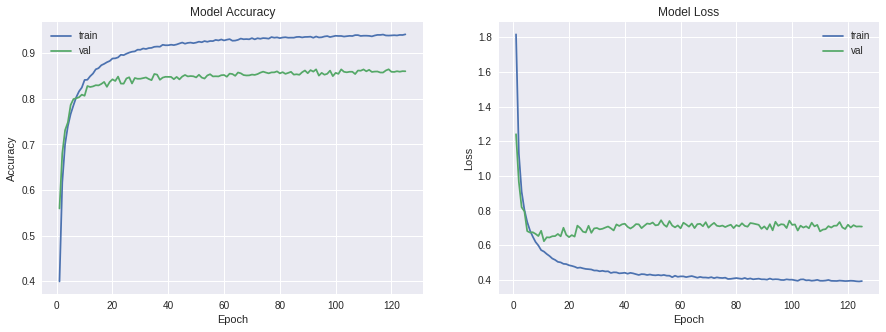

In [33]:
plot_model(model5)

Test Accuracy.

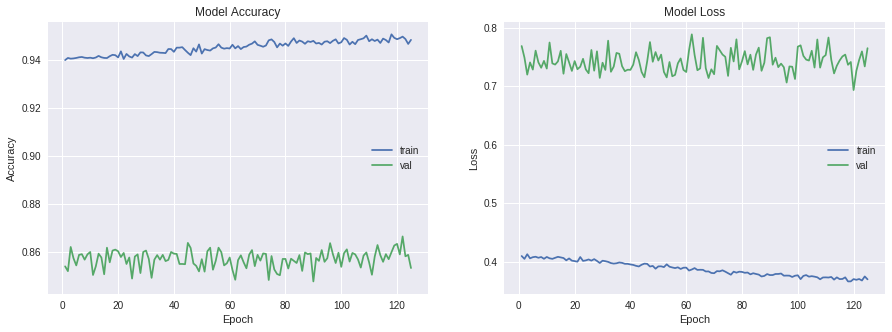

In [0]:
plot_model(model5)

As you can see we get an approx accuracy nearly reachin 87% on test data.

In [40]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 347us/step
Test loss: 0.7249692743301391
Test accuracy: 0.8534
